In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

<div align="center">
<img src="Figures/Title.png" />
</div>

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# I. Table of Contents

</div>

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# II. Introduction

</div>

**Understanding Cryptocurrency**

In recent years, trading in cryptocurrency has started to gain traction among many traders. 
However, the field, in itself, could be obscure especially for new traders trying to learn more about it and trying to penetrate the trading market. 
Before we discuss more about trading in cryptocurrency, let us discuss first what cryptocurrency is. 
There are a lot of things that we can say about cryptocurrency, but we will only be talking about the basic things that beginner traders need to know. 

Cryptocurrency is a type of digital money that is not issued or governed by any central authority like a government or bank. 
Usually, they are considered an alternative asset and investment where many people buy them to hold in hopes of the value appreciating over time (CryptoCrafted, 2025).
When trading, everyone has to deal with a trading pair which consists of two currencies: base currency and quote currency. 
The base currency represents the asset  being bought or sold.
The quote currency is used to express the value or price of one unit of the base currency.
For example, in a BTC-USDT pair, Bitcoin (BTC) is the base currency and Tether (USDT) is the quote currency, meaning the price shows how many USDT are needed to buy one BTC. 
Understanding which currency is the base and which is the quote is essential for traders to accurately interpret prices, calculate profits and losses, and manage risk (Bitcoin.com, 2025, MK Manoylov, 2024). 

To further expound, quote currencies are classified into three main categories: fiat-backed stablecoins, crypto-collaterized stablecoins, and non-stable quote currencies (Kraken Learn team, 2024). 
Fiat-backed stablecoins are pegged to traditional government-issued currencies like the US dollar or the Euro. 
This is so maintain price stability. 
Crypto-collateralized stablecoins are backed by other cryptocurrencies held in reserve to provide security and liquidity. 
Non-stable quote currencies are the ones with the most volatile price behavior. 
Good traders know which ones to choose to match their risk appetite, stability needs, and trading strategies within the crypto market. 

**Understanding Binance**

For traders to participate in trading cryptocurrency, usually they have to go through a platform in order to buy, sell, and trade Bitcoin, Ethereum, and other altcoins. 
One of the known and popular platforms is Binance. 
According to BSO Editorial (2023), Binance is one of the largest cryptocurrency exchanges in the world.
They offer the trading services for a wide range of digital assets and 530 crypto-to-crypto trading pairs alongside futures contracts for various cryptocurrencies.

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Problem Statement

</div>

For first time users, it is hard to trading in cryptocurrency could be challenging.
There are a lot of options to choose from, and a lot of quote currencies that could potentially change the value of your currencies. 
In this report, we want to figure compare the volatility, price stability, and trading activity patterns among different cryptocurrencies available on binance and different quote currencies.

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Motivation

</div>

We wanted to do this study because, as people who have no prior knowledge about cryptocurrency and Binance, we want to give data-driven guidance for beginner traders like us. 
As mentioned earlier, the Binance platform offers a vast array of options, making it difficult for beginners to understand which assets are stable, which are volatile, and when the best times to trade are. 
By analyzing historical data, we seek to uncover patterns that can inform smarter, less risky trading decisions. 
Ultimately, we want to transform complex market data into actionable insights that can help first-time users build confidence and develop effective trading strategies.

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# III. Methodology Overview

</div>

<div align="center">
<img src="Figures/Methodology Overview.png" />
</div>

The figure above shows the methodology overview of this study.
Our methodology consists of a four step process starting with the collection of historical Binance data, followed by exploratory data analysis, data processing, and the results and discussion. 
Under the results and discussion portion, we would also discuss the potential impacts this can have on investors, the perceived benefits and disadvantages, our recommendations and conclusions. 

Below would be a short summary of each of the different steps:
1. **Data Collection**: Here, we collect publicly available historical Binance data focusing on the closing price. Since the dataset is very big, we stored it in a Spark DataFrame.
2. **Exploratory Data Analysis**: Here, we prepared and cleaned the dataset to ensure that it is suitable for further analysis. EDA is used to understand the behavior of the closing price for different classifications: base currencies, quote currencies, and even their classifications. These would be further discussed later on.
3. **Data Processing**: In this step, we want to get answers for our research problem which is to find out the volatility, price stability, and trading activity patterns among the three classifications: cryptocurrency, fiat-based tokens, and stablecoin.
4. **Results and Discussion**: Based on what we find, we want to discuss what this could mean for investors, mention our perceived benefits and disadvantages, and recommend further steps. Afterwards, we will summarize findings in the recommendations and conclusion section.

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# IV. Data Collection

</div>

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Data Source

</div>

We gathered data from the Binance Full History dataset available on the Jojie-collected public datasets of the Asian Institute of Management. 
The directory is as follows: `/mnt/data/public/binance-full-history`.
This dataset consists of more than 30 Parquet files that correspond to the information per base currency in its quote currency.
The dataset, as a whole, takes up 33 GB of data, so it would not be feasible to use the typical Python operations to handle all of it. 
Instead, we used Apache Spark, and created a Spark DataFrame just to contain all the information we need.

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Data Description

</div>

The following features are consistent within all Parquet files in the Binance Full History dataset:

| Feature Name | Data Description | Data Type |
|-------------|-----------------|-----------|
| open | Opening price of the trading period | float |
| high | Highest price during the trading period | float |
| low | Lowest price during the trading period | float |
| close | Closing price of the trading period | float |
| volume | Total volume of base asset traded | float |
| quote_asset_volume | Total volume of quote asset traded | float |
| number_of_trades | Total number of trades executed | integer |
| taker_buy_base_asset_volume | Volume of base asset bought by takers | float |
| taker_buy_quote_asset_volume | Volume of quote asset bought by takers | float |
| open_time | Timestamp when the trading period started | timestamp_ntz |

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Data Collection and DataFrame Creation

</div>

Since there are a lot of files, and the entire dataset sums to a total of 33 GB, we had to use Apache Spark to handle the data. 
To summarize the code below, we created a Spark DataFrame from all the information available.
Here, we created new features: `base_currency`, `quote_currency`, and `classification`. 
These three are not anywhere in the previously shown data dictionary because they are information you can only get from the file names of the Parquet files.

In [3]:
# standard imports
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import glob
import os
import numpy as np
from functools import reduce
import math

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.window import Window
from pyspark.sql.functions import col, split, when, lit,  to_date, row_number
from pyspark.sql.functions import regexp_extract, input_file_name
from pyspark.sql.functions import year, month, dayofmonth, to_date

# scipy imports
from scipy.stats import spearmanr

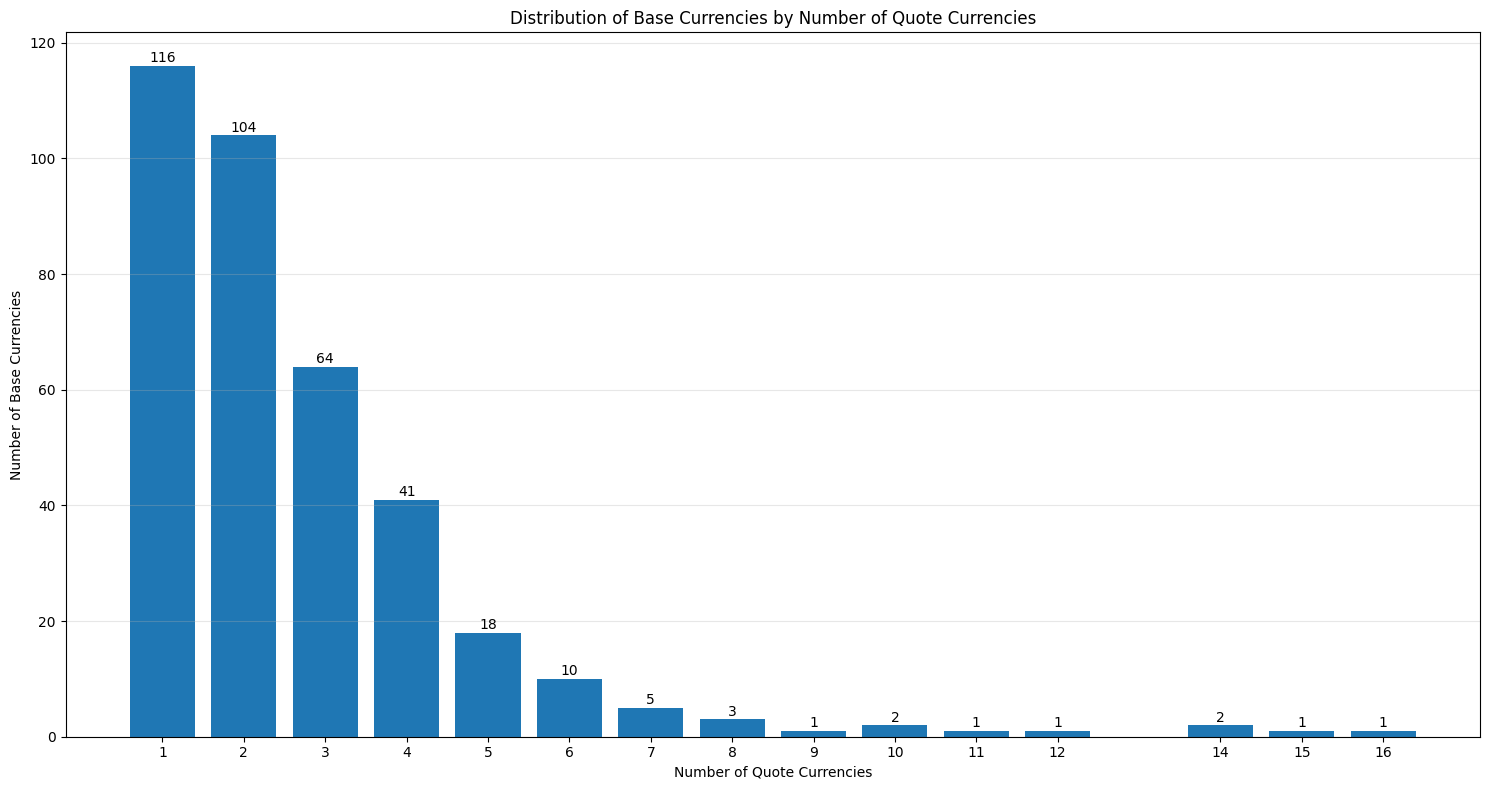

In [4]:
# Directory containing the parquet files
directory = '/mnt/data/public/binance-full-history'
files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

base_quote_counts = {}

for file in files:
    # Get base and quote per file name
    base_currency = file.split('-')[0]
    quote_currency = file.split('-')[1].replace('.parquet', '')
    
    if base_currency not in base_quote_counts:
        base_quote_counts[base_currency] = set()
    
    base_quote_counts[base_currency].add(quote_currency)

# Convert to counts
base_counts = {base: len(quotes) for base, quotes in base_quote_counts.items()}

# Create dataframe for plotting
counts_df = pd.DataFrame({
    'base_currency': list(base_counts.keys()),
    'quote_count': list(base_counts.values())
})
quote_count_distribution = counts_df['quote_count'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(15, 8))
bars = plt.bar(
    quote_count_distribution.index, quote_count_distribution.values
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Number of Quote Currencies')
plt.ylabel('Number of Base Currencies')
plt.title('Distribution of Base Currencies by Number of Quote Currencies')
plt.grid(axis='y', alpha=0.3)
plt.xticks(quote_count_distribution.index)

# Saving the figure
plt.tight_layout()
plt.savefig(
    'Figures/Distribution of Base Currencies by Number of Quote Currencies.png'
)
plt.show()

# Get top base currencies
top_bases = counts_df.nlargest(10, 'quote_count')
common_quotes = set.intersection(*(base_quote_counts[base] for base in top_bases['base_currency']))

As seen here, there are a lot of files, but most of them only have one quote currency.
Furthermore, there are also not a lot of base currencies that have a lot of the same quote currencies.
Since we want to do a comparative analysis on the different quote currencies and their relationship to the base currency, we will only look at the top 10 base currencies so that we have files that we can compare with others.
Additionally, we will also only look at the same quote currencices that are across all the top 10 base currencies.
This cuts down on a lot of irrelevant data that are not important to our analysis and makes this more computationally efficient. 

In [5]:
# Initialize Spark Session
spark = SparkSession.builder.appName("TopBasesAnalysis").getOrCreate()
directory = '/mnt/data/public/binance-full-history'

# Getting only target files
file_data = []
for base in top_bases['base_currency']:
    for quote in common_quotes:
        file_name = f"{base}-{quote}.parquet"
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            file_data.append((file_path, base, quote))

# Define classification mapping
classification_map = {
    'stablecoin': ['BUSD', 'USDT'],
    'fiat': ['EUR']
}

# Create DataFrames for each file and add columns
dfs = []
for file_path, base, quote in file_data:
    df = spark.read.parquet(file_path)
    df = df.withColumn("base_currency", lit(base)) \
           .withColumn("quote_currency", lit(quote)) \
           .withColumn("classification", 
                      when(lit(quote).isin(classification_map['stablecoin']), lit('stablecoin'))
                      .when(lit(quote).isin(classification_map['fiat']), lit('fiat'))
                      .otherwise(lit('cryptocurrency')))
    dfs.append(df)

# Union all DataFrames
spark_df = reduce(lambda df1, df2: df1.union(df2), dfs)

The schema, also features, of the new Spark DataFrame is as follows:

| Feature | Description | Data Type |
|---------|-------------|-----------|
| open | Opening price of the trading period | float |
| high | Highest price during the trading period | float |
| low | Lowest price during the trading period | float |
| close | Closing price of the trading period | float |
| volume | Total trading volume in base currency | float |
| quote_asset_volume | Total trading volume in quote currency | float |
| number_of_trades | Total number of trades executed during the period | integer |
| taker_buy_base_asset_volume | Volume of base asset bought by takers (market orders) | float |
| taker_buy_quote_asset_volume | Volume of quote asset bought by takers (market orders) | float |
| open_time | Timestamp indicating the start of the trading period | timestamp_ntz |
| base_currency | The base currency in the trading pair (e.g., BTC, ETH) | string |
| quote_currency | The quote currency in the trading pair (e.g., USDT, BUSD) | string |
| classification | Classification of the quote currency (stablecoin/fiat/cryptocurrency) | string |

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# V. Exploratory Data Analysis

</div>

# Base Currencies per Quote Currency by Year

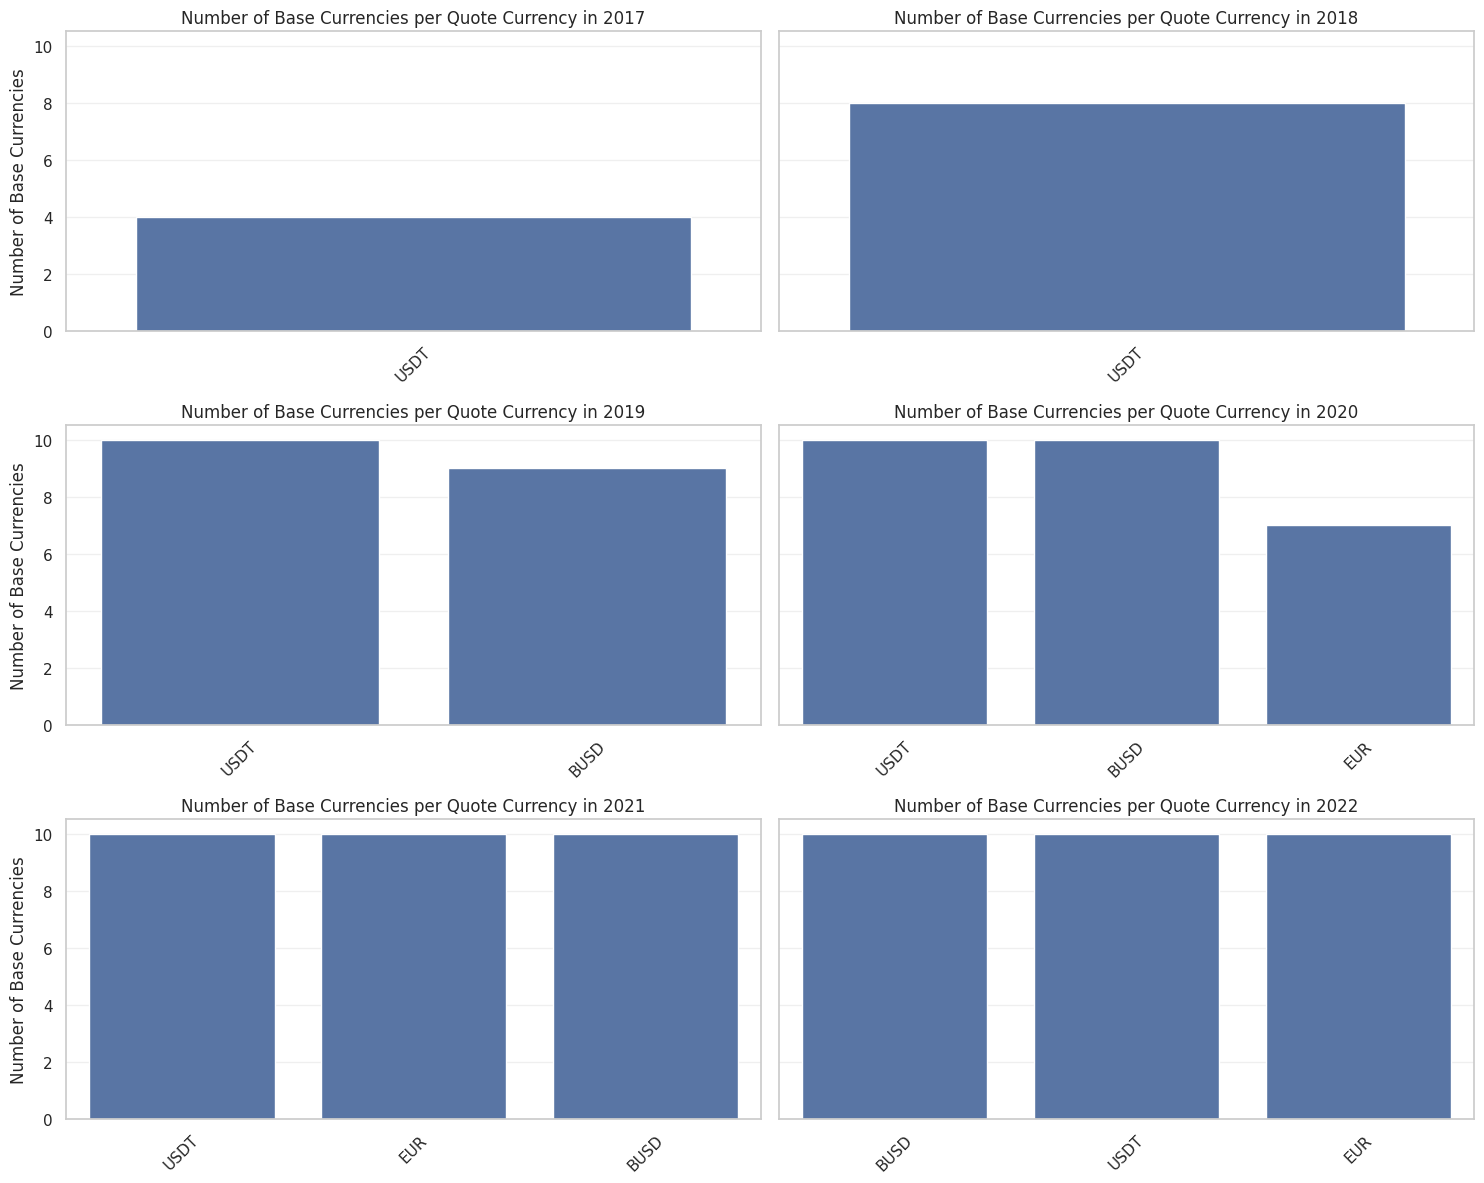

In [6]:
df = spark_df
df_with_year = df.withColumn("year", F.year("open_time"))

# counts distinct base currencies under each quote currency per year
quote_base_counts = (
    df_with_year
    .groupBy("year", "quote_currency")
    .agg(F.countDistinct("base_currency").alias("n_base_currencies"))
)

# get top 9 quote currencies by total bases across all years
top9_quotes_df = (
    quote_base_counts
    .groupBy("quote_currency")
    .agg(F.sum("n_base_currencies").alias("total_bases"))
    .orderBy(F.desc("total_bases"))
    .limit(9)
    .select("quote_currency")
)

# SAFE collect (no .rdd.flatMap)
top9_quotes = [row["quote_currency"] for row in top9_quotes_df.collect()]

# Group top 9 individually, rest = "Others" 
quote_grouped = (
    quote_base_counts
    .withColumn(
        "quote_group",
        F.when(
            F.col("quote_currency").isin(top9_quotes),
            F.col("quote_currency")
        ).otherwise(F.lit("Others"))
    )
    .groupBy("year", "quote_group")
    .agg(F.sum("n_base_currencies").alias("n_base_currencies"))
)

# convert to pandas for plotting 
plot_df = quote_grouped.toPandas()

# build subplots: one column-chart per year
sns.set(style="whitegrid")

years = sorted(plot_df["year"].unique())
n_years = len(years)

# arrange subplots in a grid (2 columns by default)
n_cols = 2
n_rows = math.ceil(n_years / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)

# if there's only one row, axes may not be a 2D array
if n_rows == 1:
    axes = [axes] if n_cols > 1 else [[axes]]

axes = [ax for row in axes for ax in (row if isinstance(row, (list, tuple, np.ndarray)) else [row])]

for i, year in enumerate(years):
    ax = axes[i]
    df_year = plot_df[plot_df["year"] == year].copy()

    # Put "Others" last
    if "Others" in df_year["quote_group"].values:
        df_main = df_year[df_year["quote_group"] != "Others"].sort_values(
            "n_base_currencies", ascending=False
        )
        df_others = df_year[df_year["quote_group"] == "Others"]
        df_year = pd.concat([df_main, df_others])
    else:
        df_year = df_year.sort_values("n_base_currencies", ascending=False)

    sns.barplot(
        data=df_year,
        x="quote_group",
        y="n_base_currencies",
        ax=ax,
    )

    ax.grid(axis='y', alpha=0.3)
    ax.set_title(f"Number of Base Currencies per Quote Currency in {year}")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Base Currencies")
    ax.tick_params(axis='x', rotation=45)

# turn off any unused axes (if n_years is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

    
plt.tight_layout()
save_path = "Figures/Base Currencies per Quote Currency.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

*Code above took around 20 seconds to load*

The column plots above show how many distinct base currencies exist within each quote currency (USDT, EUR, and BUSD) across all years of the given data. Initially, it could be observed that USDT is the only quote currency that exists in the years 2017 and 2018. Beyond that, more quote currencies are considered in the subplots, with BUSD emerging in 2019 and EUR coming in 2020. 
An article by Binance mentions that on February 3, 2019, the company announced a Launchpad project for the first time, and this event started the "*IEO (Initial Exchange Offering) wave*" that brought a rise in the number of assets being listed on the website (Binance, 2024). 
Furthermore, as the timeline leads into 2022, the market structure matures as the number of base currencies under BUSD and EUR increases.
By the conclusion of the timeline, all quote currencies have 10 base currencies under their title.

**Sources** (to be compiled later):
- Binance. (2024). 幣安七載風華，一朝雲起龍蟠！探索改變全球加密貨幣市場的七年征途 [Binance’s seven-year journey: How Binance has changed the global crypto market]. Retrieved November 23, 2025, from https://www.binance.com/en/square/post/10784043486617

# Correlation of Returns Across Three Random Base Currencies Across Target Quote Pairs 

Selected bases: ['BTC', 'LTC', 'ETH']
Years (columns): [2017, 2018, 2019, 2020, 2021, 2022]
Quotes (fixed):  ['BUSD', 'EUR', 'USDT']


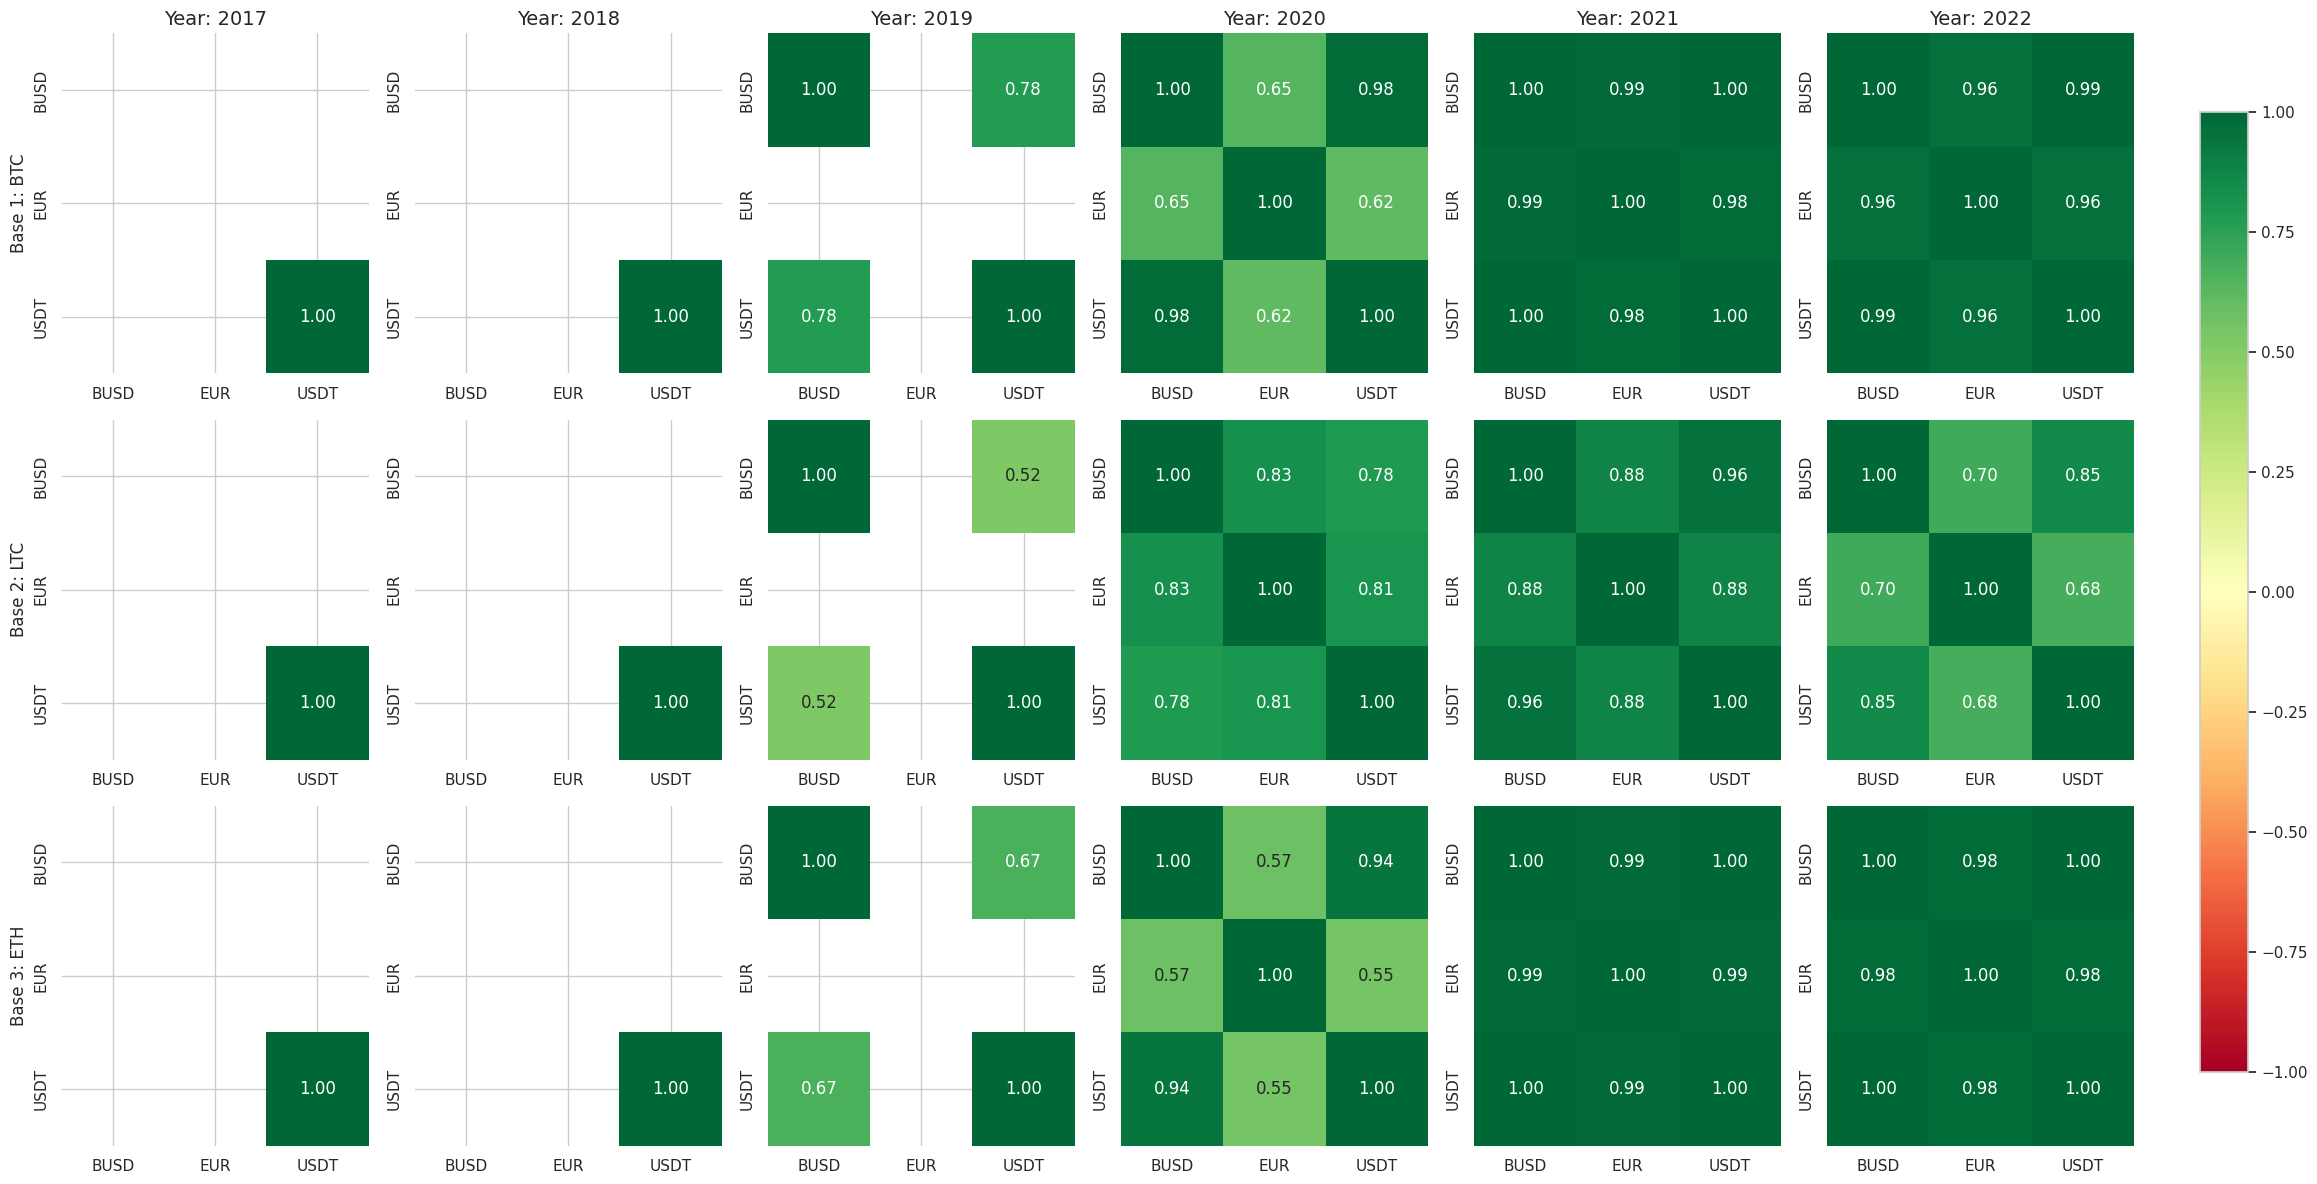

Saved to: Figures/Correlation of Returns Across Three Random Base Currencies Across Target Quote Pairs.png


In [7]:
# Compute returns
w = Window.partitionBy("base_currency", "quote_currency").orderBy("open_time")

df_returns = (
    spark_df
    .withColumn("year", F.year("open_time"))
    .withColumn("prev_close", F.lag("close").over(w))
    .withColumn(
        "return",
        (F.col("close") - F.col("prev_close")) / F.col("prev_close")
    )
    .filter(F.col("prev_close").isNotNull())
)

# Use this order so A,B,C = BUSD, EUR, USDT
target_quotes = ["BUSD", "EUR", "USDT"]

# For each base, collect set of quotes it trades against (restricted to target_quotes)
bases_with_quotes = (
    df_returns
    .filter(F.col("quote_currency").isin(target_quotes))
    .groupBy("base_currency")
    .agg(F.collect_set("quote_currency").alias("quotes"))
)

# Keep only bases that have all 3 quotes
bases_complete = (
    bases_with_quotes
    .filter(F.size("quotes") == len(target_quotes))
    .select("base_currency")
    .toPandas()["base_currency"]
    .tolist()
)

if len(bases_complete) < 3:
    raise ValueError(f"Not enough bases with all {target_quotes}. Found only: {bases_complete}")

random.seed(42)  # keep for reproducibility; remove if you want different picks each run
base_by_row = random.sample(bases_complete, 3)

# For readability in the plot
row_labels = [
    f"Base 1: {base_by_row[0]}",
    f"Base 2: {base_by_row[1]}",
    f"Base 3: {base_by_row[2]}",
]

print("Selected bases:", base_by_row)

df_sel = (
    df_returns
    .filter(F.col("base_currency").isin(base_by_row))
    .filter(F.col("quote_currency").isin(target_quotes))
)

df_small = df_sel.filter(F.minute("open_time") == 0)

# To pandas
pdf = (
    df_small
    .select("open_time", "year", "quote_currency", "base_currency", "return")
    .toPandas()
)

pdf = pdf.sort_values(["year", "quote_currency", "open_time"])

years = list(range(2017, 2023))
print("Years (columns):", years)
print("Quotes (fixed): ", target_quotes)

# Plots
n_rows = 3
n_cols = len(years)

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
    squeeze=False
)

for i, base in enumerate(base_by_row):
    for j, year in enumerate(years):
        ax = axes[i, j]

        sub = pdf[
            (pdf["base_currency"] == base) &
            (pdf["year"] == year) &
            (pdf["quote_currency"].isin(target_quotes))
        ]

        if sub.empty:
            ax.axis("off")
            continue

        wide = sub.pivot_table(
            index="open_time",
            columns="quote_currency",
            values="return"
        )
        wide = wide.reindex(columns=target_quotes)

        corr = wide.corr()

        if corr.isna().all().all():
            ax.axis("off")
            continue

        sns.heatmap(
            corr,
            vmin=-1,
            vmax=1,
            cmap="RdYlGn",
            annot=True,
            fmt=".2f",
            xticklabels=target_quotes,
            yticklabels=target_quotes,
            ax=ax,
            cbar=False
        )

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")

        if i == 0:
            ax.set_title(f"Year: {year}", fontsize=14)

        if j == 0:
            ax.set_ylabel(row_labels[i], fontsize=12)

plt.tight_layout(rect=[0, 0, 0.90, 1]) 

# BIG GLOBAL COLORBAR ON THE RIGHT
norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(sm, cax=cbar_ax)

# saving the figure
save_path = "Figures/Correlation of Returns Across Three Random Base Currencies Across Target Quote Pairs.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", save_path)

*Code above takes around 1 minute and 5 seconds to load*

The correlation plots above describe the relationship between the returns of three random base coins (BTC, LTC, and ETH) and fixed quote currencies (BUSD, EUR, and USDT) throughout all years of the dataset. 
In connection with the previous column chart analysis, some cells within the correlation plots of years 2017, 2018, and 2019 are left empty because the expansion of Binance assets did not occur until 2019. 
Given that all of the correlation cells are nearer to the value of 1.00 (colored by a shade of green), the value of the base coin's return gives a small difference when there is a change in the quote currency. 
This is most evident in the correlation plots of BTC and ETH in years 2021 and 2022 wherein all the correlation values lie within the range of 0.95 to 1.00. 
Some explanations for the lower correlations could be that:
1. The market of the base coin has not matured enough yet. This is evident when the correlation plots of the base coins in earlier years are observed. Lesser users engaging with the specific coin means lesser data for correlation value, therefore the values in consideration are more sensitive to randomness. 
2. Difference in macroeconomic conditions. More specifically, the value of EUR is tied to the real world currency of Europe, the Euro. This means that the value of any cryptocurrency tied to EUR could transitively be affected by changes in the Euro, which could cause the return behavior to deivate from those tied to US currencies (USDT and BUSD).

Given that most of the correlation plots show similar results, the return values of the base currency don't have a strong dependency on the quote currency.

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# VI. Data Processing

</div>

In this portion, we are trying to fulfill our goals where we compare volatility, price stability, and trading activity patterns.

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Volatility Comparison

</div>

In [8]:
def calculate_volatility_measures(
    spark_df,
    output_dir='Figures',
    rolling_window_days=30,
    annualization_factor=np.sqrt(365),
    min_rolling_obs=10
):
    os.makedirs(output_dir, exist_ok=True)

    spark_daily = spark_df.withColumn('date', to_date('open_time'))

    rn_window = (
        Window.partitionBy('base_currency', 'quote_currency', 'date')
        .orderBy(F.col('open_time').desc())
    )
    spark_daily = (
        spark_daily
        .withColumn('_rn', row_number().over(rn_window))
        .filter(col('_rn') == 1)
        .drop('_rn')
    )

    lag_window = (
        Window.partitionBy('base_currency', 'quote_currency')
        .orderBy('date')
    )

    spark_daily = (
        spark_daily
        .withColumn('prev_close', F.lag('close').over(lag_window))
        .withColumn(
            'log_return',
            F.when(
                F.col('prev_close').isNotNull(),
                F.log(col('close') / col('prev_close'))
            ).otherwise(F.lit(None)),
        )
    )

    spark_daily = spark_daily.filter(col('log_return').isNotNull())
    spark_daily = spark_daily.withColumn('year', F.year(F.col('date')))

    annual_vol_df = (
        spark_daily
        .groupBy('base_currency', 'quote_currency', 'year', 'classification')
        .agg(
            (
                F.stddev('log_return') * F.lit(annualization_factor)
            ).alias('annual_volatility'),
            F.count('log_return').alias('n_days'),
        )
        .filter(col('annual_volatility').isNotNull())
        .orderBy('base_currency', 'quote_currency', 'year')
    )

    rolling_w = (
        Window.partitionBy('base_currency', 'quote_currency')
        .orderBy('date')
        .rowsBetween(-(rolling_window_days - 1), 0)
    )
    spark_daily = spark_daily.withColumn(
        'rolling_std',
        F.stddev('log_return').over(rolling_w),
    )
    spark_daily = spark_daily.withColumn(
        'rolling_vol_annualized',
        F.when(
            F.col('rolling_std').isNotNull(),
            F.col('rolling_std') * F.lit(annualization_factor),
        ).otherwise(None),
    )

    count_w = (
        Window.partitionBy('base_currency', 'quote_currency')
        .orderBy('date')
        .rowsBetween(-(rolling_window_days - 1), 0)
    )

    spark_daily = spark_daily.withColumn(
        'rolling_count',
        F.count('log_return').over(count_w),
    )
    spark_daily = spark_daily.withColumn(
        'rolling_vol_annualized',
        F.when(
            col('rolling_count') >= min_rolling_obs,
            col('rolling_vol_annualized'),
        ).otherwise(F.lit(None)),
    )

    annual_vol_pd = annual_vol_df.toPandas()
    rolling_pd = (
        spark_daily.select(
            'base_currency',
            'quote_currency',
            'date',
            'rolling_vol_annualized',
            'rolling_count',
            'classification',
        ).toPandas()
    )

    try:
        base_list = sorted(annual_vol_pd['base_currency'].unique())
        n_plots = min(len(base_list), 10)
        cols = 5
        rows = math.ceil(n_plots / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
        axes = axes.flatten()
        all_years = sorted(annual_vol_pd['year'].unique())

        if len(all_years) == 0:
            print("No annual data to plot.")
        else:
            for i, base in enumerate(base_list[:n_plots]):
                ax = axes[i]
                bdf = annual_vol_pd[
                    annual_vol_pd['base_currency'] == base
                ]
                for quote in sorted(bdf['quote_currency'].unique()):
                    qdf = bdf[bdf['quote_currency'] == quote]
                    ax.plot(
                        qdf['year'],
                        qdf['annual_volatility'],
                        marker='o',
                        label=quote,
                    )
                ax.set_title(f'{base} annualized vol')
                ax.set_xlabel('Year')
                ax.set_ylabel('Annual volatility')
                ax.set_xticks(all_years)
                ax.grid(alpha=0.3)
                ax.legend(fontsize=8)

            for j in range(n_plots, len(axes)):
                axes[j].set_visible(False)

            plt.suptitle(
                'Annualized Volatility by Base Currency (per quote)',
                fontsize=14,
                y=0.98,
            )
            plt.tight_layout(rect=[0, 0, 1, 0.97])
            out1 = os.path.join(output_dir, 'annual_volatility_by_year.png')
            plt.savefig(out1, dpi=300, bbox_inches='tight')
            plt.close()
            print("Saved:", out1)
    except Exception as e:
        print("Plotting annual volatility failed:", e)

    try:
        counts = (
            rolling_pd.groupby(['base_currency', 'quote_currency'])
            .size()
            .reset_index(name='n')
        )
        top_series = counts.sort_values('n', ascending=False).head(4)
        fig, axes = plt.subplots(
            len(top_series),
            1,
            figsize=(12, 3 * len(top_series)),
        )
        if len(top_series) == 1:
            axes = [axes]

        for ax, (_, row) in zip(axes, top_series.iterrows()):
            base = row['base_currency']
            quote = row['quote_currency']
            ser = rolling_pd[
                (rolling_pd['base_currency'] == base)
                & (rolling_pd['quote_currency'] == quote)
            ].sort_values('date')
            ax.plot(
                ser['date'],
                ser['rolling_vol_annualized'],
                marker='.',
                linewidth=1,
            )
            ax.set_title(
                f'Rolling {rolling_window_days}-day '
                f'annualized vol: {base}-{quote}'
            )
            ax.set_ylabel('Annualized vol')
            ax.set_xlabel('Date')
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        out2 = os.path.join(
            output_dir,
            'rolling_volatility_examples.png',
        )
        plt.savefig(out2, dpi=300, bbox_inches='tight')
        plt.close()
        print("Saved:", out2)
    except Exception as e:
        print("Plotting rolling volatility failed:", e)

    return annual_vol_pd, rolling_pd

annual_volatility_df, rolling_volatility_df = calculate_volatility_measures(
    spark_df
)

Saved: Figures/annual_volatility_by_year.png
Saved: Figures/rolling_volatility_examples.png


The code above was generated with ChatGPT.

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Volume-Volatility Relationship

</div>

In [ ]:
def analyze_volume_volatility(spark_df, output_dir='Figures'):
    """
    Analyze volume–return relationships for randomly selected base and quote
    currencies and generate a 3x3 grid of scatter plots with shared axes.
    """
    os.makedirs(output_dir, exist_ok=True)

    spark_daily = spark_df.withColumn('date', to_date('open_time'))

    rn_window = (
        Window.partitionBy('base_currency', 'quote_currency', 'date')
        .orderBy(F.col('open_time').desc())
    )

    spark_daily = (
        spark_daily
        .withColumn('_rn', row_number().over(rn_window))
        .filter(col('_rn') == 1)
        .drop('_rn')
    )

    lag_window = (
        Window.partitionBy('base_currency', 'quote_currency')
        .orderBy('date')
    )

    spark_daily = (
        spark_daily
        .withColumn('prev_close', F.lag('close').over(lag_window))
        .withColumn(
            'return',
            F.when(
                F.col('prev_close').isNotNull(),
                (col('close') - col('prev_close')) / col('prev_close')
            ).otherwise(None)
        )
    )

    spark_daily = spark_daily.filter(col('return').isNotNull())

    volume_volatility_df = spark_daily.select(
        'base_currency',
        'quote_currency',
        'date',
        'volume',
        'return'
    ).toPandas()

    quotes = volume_volatility_df['quote_currency'].unique()
    selected_quotes = np.random.choice(
        quotes,
        size=min(3, len(quotes)),
        replace=False
    )

    bases = volume_volatility_df['base_currency'].unique()
    selected_bases = np.random.choice(
        bases,
        size=min(3, len(bases)),
        replace=False
    )

    fig, axes = plt.subplots(
        3, 3,
        figsize=(18, 14),
        sharex=True,
        sharey=True
    )

    for i, base in enumerate(selected_bases):
        for j, quote in enumerate(selected_quotes):
            ax = axes[i, j]

            data = volume_volatility_df[
                (volume_volatility_df['base_currency'] == base)
                & (volume_volatility_df['quote_currency'] == quote)
            ]

            if data.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center')
                ax.set_axis_off()
                continue

            returns = data['return']
            volumes = data['volume']

            ax.scatter(volumes, returns, alpha=0.6, s=10)

            if i == 0:
                ax.set_title(f"Quote Currency: {quote}")

            if j == 0:
                ax.set_ylabel(f"Base Currency: {base}\nDaily Return")

            corr, pval = spearmanr(volumes, returns)

            ax.text(
                0.05,
                0.95,
                f'r={corr:.2f}\np={pval:.3f}',
                transform=ax.transAxes,
                va='top',
                fontsize=9,
                bbox=dict(
                    boxstyle='round',
                    facecolor='wheat',
                    alpha=0.75
                )
            )

            ax.grid(True, alpha=0.3)

    fig.text(0.5, 0.04, "Daily Volume", ha='center', fontsize=13)

    plt.suptitle(
        "Volume vs Return Across Selected Base and Quote Currencies",
        fontsize=18,
        fontweight='bold'
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.96])

    out_path = os.path.join(output_dir, "volume_return_3x3.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"Figure saved to: {out_path}")

    return volume_volatility_df

volume_volatility_df = analyze_volume_volatility(spark_df)

The code above was generated with ChatGPT.

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Price Stability

</div>

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# VII. Results and Discussion

</div>

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# VIII. Conclusion and Recommendations

</div>

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Conclusion

</div>

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Recommendations

</div>

### Limitations of the Study

insert your text here

### Recommendations for Readers

insert your text here

### Future Work

insert your text here

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# IX. References

</div>

Bitcoin.com. (2025). *Base and Quote Currency Explained*. Bitcoin.com Markets. https://markets.bitcoin.com/glossary/base-and-quote-currency

BSO Editorial. (2023). *What is Binance?* BSO. https://www.bso.co/glossary/what-is-binance

CryptoCrafted. (2025, May 2). *What is Cryptocurrency? The Ultimate Beginner’s Guide*. https://www.cryptocrafted.org/what-is-cryptocurrency

Kraken Learn team. (2024, December 18). *Types of Cryptocurrency | Kraken*. https://www.kraken.com/learn/types-of-cryptocurrency

MK Manoylov. (2024, August 30). *Beginner’s guide to cryptocurrency trading: different pair types*. The Block. https://www.theblock.co/learn/286332/beginners-guide-to-cryptocurrency-trading-different-pair-types

<div style="background-color: #270f47; color: #eed47c; padding: 15px; text-align: left; border-radius: 5px;">

# X. Supplementary

</div>

This portion just contains code that was created, but not really focused or talked about in the previous sections because it did not really help with carrying out the narrative of the report.

**Disclaimer**: Some code in this section have been commented out because they took a long time to run on Jojie, but the outputs are displayed with some description attached.

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Total File Size

</div>

In [1]:
# # Getting the total size of files
# total_size_bytes = 0

# for base_currency in top_bases['base_currency']:
#     for quote_currency in common_quotes:
#         file_name = f"{base_currency}-{quote_currency}.parquet"
#         if file_name in files:
#             file_path = os.path.join(directory, file_name)
#             total_size_bytes += os.path.getsize(file_path)

# # Convert totals
# total_size_mb = total_size_bytes / (1024 * 1024)
# total_size_gb = total_size_bytes / (1024 * 1024 * 1024)

# # Calculate all-file totals
# total_all_files_bytes = sum(os.path.getsize(os.path.join(directory, f)) for f in files)
# total_all_files_gb = total_all_files_bytes / (1024 * 1024 * 1024)

# # Output
# print(f"{'TOTAL (Top Bases + Common Quotes)':<35} {total_size_gb:>8.2f} GB ({total_size_mb:>.1f} MB)")
# print(f"{'Percentage of All Data':<35} {(total_size_gb/total_all_files_gb)*100:>8.1f}%")
# print(f"{'TOTAL (All Files)':<35} {total_all_files_gb:>8.2f} GB")

<div style="color: #270f47; padding: 15px; text-align: left; border-radius: 5px;">

## Closing Prices per Base Currency per Year

</div>

In [2]:
# # Create output directory
# output_dir = 'Figures'
# os.makedirs(output_dir, exist_ok=True)

# # Extract year from open_time and convert to date for better plotting
# spark_df = spark_df.withColumn("year", year("open_time"))
# spark_df = spark_df.withColumn("date", to_date("open_time"))

# # Get unique years and base currencies
# years = [row['year'] for row in spark_df.select("year").distinct().collect()]
# years.sort()
# base_currencies = [
#     row['base_currency'] for row in spark_df.select("base_currency").distinct().collect()
# ]

# print(f"Years available: {years}")
# print(f"Base currencies: {base_currencies}")

# # For each base currency, create a figure with subplots for each year
# for base_currency in base_currencies:
#     print(f"Processing {base_currency}...")

#     # Filter data for the current base currency
#     currency_df = spark_df.filter(spark_df.base_currency == base_currency)

#     # Create figure with 2 rows, 3 columns (for up to 6 years)
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#     axes = axes.flatten()

#     # Get available years for this currency and sort them
#     currency_years = [row['year'] for row in currency_df.select("year").distinct().collect()]
#     currency_years.sort()

#     # Plot each year in a separate subplot
#     for i, year_val in enumerate(currency_years):
#         if i >= 6:
#             break

#         # Filter data for the specific year
#         year_data = currency_df.filter(currency_df.year == year_val)

#         # Convert to pandas for plotting
#         pandas_df = year_data.select("date", "close", "quote_currency").toPandas()

#         # Plot each quote currency as a separate line
#         ax = axes[i]
#         for quote_currency in pandas_df['quote_currency'].unique():
#             quote_data = pandas_df[pandas_df['quote_currency'] == quote_currency]
#             quote_data = quote_data.sort_values('date')
#             ax.plot(
#                 quote_data['date'],
#                 quote_data['close'],
#                 label=quote_currency,
#                 linewidth=1,
#                 alpha=0.7
#             )

#         ax.set_title(f'{base_currency} - {year_val}', fontsize=12, fontweight='bold')
#         ax.set_xlabel('Date')
#         ax.set_ylabel('Closing Price')
#         ax.tick_params(axis='x', rotation=45)
#         ax.legend(fontsize=8)
#         ax.grid(True, alpha=0.3)

#     # Hide empty subplots if we have fewer than 6 years
#     for i in range(len(currency_years), 6):
#         axes[i].set_visible(False)

#     plt.tight_layout()

#     # Save the figure
#     filename = os.path.join(output_dir, f'{base_currency}_volatility_comparison.png')
#     plt.savefig(filename, dpi=300, bbox_inches='tight')
#     plt.close()

#     print(f"Saved: {filename}")

# print("All volatility comparison plots have been generated!")